In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE

%matplotlib inline

pd.options.display.max_columns=200

In [15]:
import re

In [2]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Helper functions

In [49]:
def extract_all_nums(string):
    all_nums = []
    for word in string.split(" "):
        number = ''.join(filter(str.isdigit, word))
        if number:
            all_nums.append(int(number))
        
    return all_nums

In [59]:
def extract_all_nums_min(string):
    result = extract_all_nums(string)
    if result:
        return np.min(result)
    else:
        return 0

In [60]:
def extract_all_nums_max(string):
    result = extract_all_nums(string)
    if result:
        return np.max(result)
    else:
        return 0

In [46]:
def extract_letters(string):
    string_return = []
#    thing = re.split("[^a-zA-Z]*", string)
    thing = re.split("[^a-zA-Z]*", string)    
    
    for item in thing:
        if item.isalpha():
            #print(item)
            #print("YEAH")
            string_return.append(item)
            
    return set(string_return)

## Add features 

In [189]:
class TitanicDataProcessor():
    """
    Takes in the raw data frame and generates required features
    """
    def __init__(self, train_or_test="train"):
        self.train_or_test = train_or_test
        self.current_features = ['Pclass',
                                 'Age',
                                 'SibSp',
                                 'male',
                                 'family_size',
                                 'cabin_B',
                                 'cabin_E',
                                 'cabin_F']
        
    def read_data(self):
        if self.train_or_test == "train":
            print("TRAINING")
            self.data = pd.read_csv("train.csv")
            self.target = self.data['Survived']
            
        elif self.train_or_test == "test":
            print("TESTING")
            self.data = pd.read_csv("test.csv")
            self.data_raw = self.data.copy() 
        
    def add_initial_features(self):
        df = self.data
            # Set Age to median Age
        df.loc[df['Age'].isnull(),
              'Age'] = df['Age'].median()  
        bins_age = [x for x in range(0, 100, 5)]
        df['Age_binned'] = pd.cut(df['Age'], bins_age, labels=bins_age[:-1])

        bins_age_2 = [0, 5, 15, np.inf]
        df['Age_binned_2'] = pd.cut(df['Age'], bins_age_2)
        df['fare_bin'] = pd.cut(df['Fare'], bins=10)


        bins = [x for x in range(-1, 101, 5)]    
        bins.append(np.inf)
        df['fare_binned'] = pd.cut(df['Fare'], bins, labels=bins[:-1])

        bins_2 = [-1, 50, 75, np.inf]
        labels = [1,2,3]
        df['fare_binned_2'] = pd.cut(df['Fare'], bins_2, labels=labels)

        df['Pclass_norm'] = scaler.fit_transform(np.array(df['Pclass']).reshape(-1, 1))

        sex_dummies = pd.get_dummies(df['Sex']).drop(['female'], axis=1)
        df = df.join(sex_dummies)

        df_embarked = pd.get_dummies(df['Embarked']).drop(['C'], axis=1)
        df = df.join(df_embarked)

        df['family_size'] = df['SibSp'].fillna(0) + df['Parch'].fillna(0)

        self.data = df
        
    def create_cabin_cols(self):
        df = self.data
        df['cabin_count'] = df['Cabin'].str.split(" ").str.len()

        df['cabin_letters'] = df['Cabin'].astype(str).apply(extract_letters)
        df.loc[df['Cabin'].isnull(),
               'cabin_letters'] = pd.np.NaN

        df['cabin_numbers'] = df['Cabin'].astype(str).apply(extract_all_nums)
        df.loc[df['Cabin'].isnull(),
               'cabin_numbers'] = pd.np.NaN

        df['cabin_numbers_min'] = df['Cabin'].astype(str).apply(extract_all_nums_min)
        df.loc[df['Cabin'].isnull(),
               'cabin_numbers_min'] = pd.np.NaN

        df['cabin_numbers_max'] = df['Cabin'].astype(str).apply(extract_all_nums_max)
        df.loc[df['Cabin'].isnull(),
               'cabin_numbers_max'] = pd.np.NaN

        ## Create dummy values 
        cabin_letters = ['A','B','C','D','E','F','G','T']

        for cabin in cabin_letters:
            cabin_col = f"cabin_{cabin}"
            df[cabin_col] = 0
            df.loc[df['cabin_letters'].astype(str).fillna("ZZZZ").str.contains(cabin),
                  cabin_col] = 1       
            
        self.data = df
        
    def create_ticket_cols(self):
        df = self.data
        df['ticket_str_length']= df['Ticket'].str.len()

        df['ticket_is_digit'] = 0
        df.loc[df['Ticket'].str.isdigit(),
              'ticket_is_digit'] = 1
        self.data = df
        
    def grab_current_features(self):
        self.df_features = self.data[self.current_features]
        
    def run(self):
        self.read_data()
        self.add_initial_features()
        self.create_cabin_cols()
        self.create_ticket_cols()
        self.grab_current_features()

In [248]:
self = TitanicDataProcessor()

In [249]:
self.run()

TRAINING


/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:66: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_letters'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:70: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:74: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers_min'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:78: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers_max'] = pd.np.NaN


In [251]:
df = self.data

## Which features have strong correlation??

In [252]:
corr_matrix = df.corr(method='pearson')  # 'pearson' is default
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass_norm,male,Q,S,family_size,cabin_count,cabin_numbers_min,cabin_numbers_max,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,ticket_str_length,ticket_is_digit
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658,-0.035144,0.042939,-0.033606,0.022148,-0.040143,-0.011218,0.045866,0.045721,-0.003256,0.069552,-0.040957,0.022828,0.034404,-0.035772,-0.037859,-0.013814,-0.046022,0.072291
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.338481,-0.543351,0.003650,-0.155660,0.016639,-0.034218,-0.051917,-0.051923,0.022287,0.175095,0.114652,0.150716,0.150716,0.057935,-0.017955,-0.026456,-0.055331,0.001492
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,1.000000,0.131900,0.221009,0.081720,0.065997,0.024595,-0.064728,-0.068436,-0.204934,-0.369572,-0.417048,-0.278690,-0.221793,0.011063,0.073625,-0.052496,0.054098,0.079763
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.339898,0.081163,-0.031415,-0.014665,-0.245619,-0.178921,0.033597,0.026732,0.121732,0.096080,0.115188,0.135674,0.118091,-0.076393,-0.059135,0.040285,-0.018548,-0.030025
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,0.083081,-0.114631,-0.026354,0.070941,0.890712,0.401090,-0.043174,-0.028661,-0.046266,-0.034538,0.029251,-0.017575,-0.033751,0.001706,-0.019159,-0.015907,-0.013691,-0.080768
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,0.018443,-0.245489,-0.081228,0.063036,0.783111,0.493978,-0.098279,-0.080429,-0.040325,0.056498,0.030736,-0.019125,-0.011748,0.023694,0.036749,-0.015878,-0.020454,-0.035762
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.549500,-0.182333,-0.117216,-0.166603,0.217138,0.517653,0.072539,0.091127,0.019549,0.386297,0.364318,0.098878,0.051749,-0.033093,-0.037921,0.002224,-0.016002,-0.173170
Pclass_norm,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,1.000000,0.131900,0.221009,0.081720,0.065997,0.024595,-0.064728,-0.068436,-0.204934,-0.369572,-0.417048,-0.278690,-0.221793,0.011063,0.073625,-0.052496,0.054098,0.079763
male,0.042939,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,0.131900,1.000000,-0.074115,0.125722,-0.200988,-0.016150,0.052998,0.050867,0.078271,-0.109689,-0.058649,-0.079248,-0.054368,-0.008202,-0.040796,0.024728,0.080280,-0.032507
Q,-0.033606,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,0.221009,-0.074115,1.000000,-0.496624,-0.058592,-0.046536,0.096191,0.094803,-0.040246,-0.072579,-0.049776,-0.060318,-0.039167,-0.004113,-0.027369,-0.010310,-0.100172,0.172297


In [253]:
# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
 
        # Print variables with high correlation
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

Pclass_norm Pclass 0.9999999999999991
family_size SibSp 0.890711671869885
family_size Parch 0.7831107750000584
cabin_numbers_max cabin_numbers_min 0.9993894774980472
ticket_is_digit ticket_str_length -0.7582987568976797


## Which features can we drop??? 

In [257]:
df = df.drop(['Pclass_norm','family_size','cabin_numbers_min','ticket_is_digit'], axis=1)

## What about correlation with tagret variable?? 

In [264]:
corr_matrix = df.corr()
 
# Isolate the column corresponding to `exam_score`
corr_target = corr_matrix[['Survived']].drop(labels=['Survived'])
corr_target['Survived_ABS'] = abs(corr_target['Survived'])
corr_target = corr_target.sort_values("Survived_ABS")
corr_target

,Survived,Survived_ABS
Q,0.003650,0.003650
PassengerId,-0.005007,0.005007
cabin_G,-0.017955,0.017955
cabin_A,0.022287,0.022287
cabin_T,-0.026456,0.026456
cabin_count,-0.034218,0.034218
SibSp,-0.035322,0.035322
cabin_numbers_max,-0.051923,0.051923
ticket_str_length,-0.055331,0.055331
cabin_F,0.057935,0.057935


In [266]:
df = df.drop(['Q','PassengerId'], axis=1)

In [267]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_binned,Age_binned_2,fare_bin,fare_binned,fare_binned_2,male,S,cabin_count,cabin_letters,cabin_numbers,cabin_numbers_max,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,ticket_str_length
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20,"(15.0, inf]","(-0.512, 51.233]",4,1,1,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,9
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35,"(15.0, inf]","(51.233, 102.466]",69,2,0,0,1.0,{C},[85],85.0,0,0,1,0,0,0,0,0,8
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,25,"(15.0, inf]","(-0.512, 51.233]",4,1,0,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,16
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30,"(15.0, inf]","(51.233, 102.466]",49,2,0,1,1.0,{C},[123],123.0,0,0,1,0,0,0,0,0,6
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30,"(15.0, inf]","(-0.512, 51.233]",4,1,1,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,25,"(15.0, inf]","(-0.512, 51.233]",9,1,1,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,6
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,15,"(15.0, inf]","(-0.512, 51.233]",29,1,0,1,1.0,{B},[42],42.0,0,1,0,0,0,0,0,0,6
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,25,"(15.0, inf]","(-0.512, 51.233]",19,1,0,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,10
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,25,"(15.0, inf]","(-0.512, 51.233]",29,1,1,0,1.0,{C},[148],148.0,0,0,1,0,0,0,0,0,6


# What about this mutual info stuff?

In [ ]:
from sklearn.feature_selection import mutual_info_regression 
print(mutual_info_regression(X_enc, y, random_state=68))

In [ ]:


from sklearn.feature_selection import SelectKBest
from functools import partial
 
score_func = partial(mutual_info_regression, discrete_features=[0], random_state=68)
 
# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=3)
 
print(selection.fit_transform(X_enc, y))

In [176]:
X = self.df_features
y = self.target

In [177]:
lr = LogisticRegression(max_iter=1000)

In [178]:
lr.fit(X, y)

LogisticRegression(max_iter=1000)

In [179]:
INITIAL_SCORE = lr.score(X, y)
INITIAL_SCORE

0.8181818181818182

In [208]:
X.shape

(891, 8)

In [209]:
# Set up SFS parameters
sffs = SFS(estimator=lr,
           k_features=8, # number of features to select
           forward=True,
           floating=True,
           scoring='accuracy',
           cv=0)

sffs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          floating=True, k_features=8, scoring='accuracy')

/Users/amlvt225/anaconda3/envs/data_science_env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/amlvt225/anaconda3/envs/data_science_env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


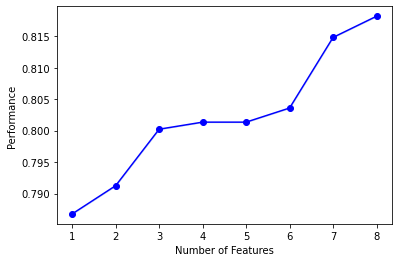

In [211]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sffs.get_metric_dict())
plt.show()

In [212]:
sffs.subsets_[8]['avg_score']

0.8181818181818182

## What about backwards?

In [213]:
# Set up SFS parameters
sfbs = SFS(estimator=lr,
           k_features=3, # number of features to select
           forward=False,
           floating=True,
           scoring='accuracy',
           cv=0)

sfbs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          floating=True, forward=False, k_features=3,
                          scoring='accuracy')

/Users/amlvt225/anaconda3/envs/data_science_env/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/amlvt225/anaconda3/envs/data_science_env/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


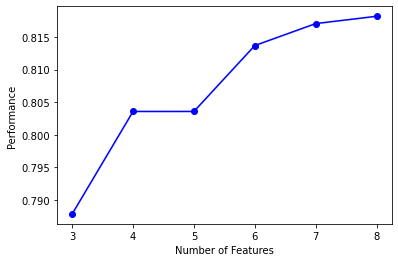

In [214]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfbs.get_metric_dict())
plt.show()

In [216]:
sfbs.get_metric_dict()[8]['avg_score']

0.8181818181818182

In [215]:
sfbs.get_metric_dict()[8]['feature_names']

('Pclass',
 'Age',
 'SibSp',
 'male',
 'family_size',
 'cabin_B',
 'cabin_E',
 'cabin_F')

In [141]:
X_best = X[list(sfbs.get_metric_dict()[8]['feature_names'])]

In [166]:
X_best.columns.tolist()

['Pclass',
 'Age',
 'SibSp',
 'male',
 'family_size',
 'cabin_B',
 'cabin_E',
 'cabin_F']

In [143]:
lr.fit(X_best, y)

LogisticRegression(max_iter=1000)

In [144]:
lr.score(X_best, y)

0.8181818181818182

In [ ]:
lr.predict()

## What about RFE? 

In [217]:
X_std = StandardScaler().fit_transform(X)

In [218]:
X_std

array([[ 0.82737724, -0.56573646,  0.43279337, ..., -0.23598136,
        -0.19611614, -0.12168146],
       [-1.56610693,  0.66386103,  0.43279337, ..., -0.23598136,
        -0.19611614, -0.12168146],
       [ 0.82737724, -0.25833709, -0.4745452 , ..., -0.23598136,
        -0.19611614, -0.12168146],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ..., -0.23598136,
        -0.19611614, -0.12168146],
       [-1.56610693, -0.25833709, -0.4745452 , ..., -0.23598136,
        -0.19611614, -0.12168146],
       [ 0.82737724,  0.20276197, -0.4745452 , ..., -0.23598136,
        -0.19611614, -0.12168146]])

In [223]:
lr = LogisticRegression(max_iter=1000)

rfe = RFE(estimator=lr,
          n_features_to_select=16,
         )

In [224]:
rfe.fit(X_std, y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=16)

In [225]:
rfe_df = pd.DataFrame({'features':X.columns,
             "ranking":rfe.ranking_,
             "to_keep": rfe.support_}).sort_values("ranking")
rfe_df

,features,ranking,to_keep
0,Pclass,1,True
1,Age,1,True
2,SibSp,1,True
3,male,1,True
4,family_size,1,True
5,cabin_B,1,True
6,cabin_E,1,True
7,cabin_F,1,True


In [226]:
rfe.score(X_std, y)

0.813692480359147

# KAGGLE TEST

## Load test data 

In [190]:
tester = TitanicDataProcessor("test")
tester.run()

TESTING


/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:66: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_letters'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:70: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:74: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers_min'] = pd.np.NaN
/var/folders/0n/f4t27bkj4qv8ch75963kg78c0000gn/T/ipykernel_16719/3925809525.py:78: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  'cabin_numbers_max'] = pd.np.NaN


## Run test features through our model 

In [191]:
X_test = tester.df_features
predictor = lr.predict(X_test)

## Compile and save dataset

In [200]:
df_kaggle = tester.data_raw.copy()
df_kaggle['Survived'] = predictor
df_kaggle = df_kaggle[['PassengerId','Survived']]

df_kaggle.to_csv("prediciton_3.csv", index=False)

In [228]:
X

,Pclass,Age,SibSp,male,family_size,cabin_B,cabin_E,cabin_F
0,3,22.0,1,1,1,0,0,0
1,1,38.0,1,0,1,0,0,0
2,3,26.0,0,0,0,0,0,0
3,1,35.0,1,0,1,0,0,0
4,3,35.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
886,2,27.0,0,1,0,0,0,0
887,1,19.0,0,0,0,1,0,0
888,3,28.0,1,0,3,0,0,0
889,1,26.0,0,1,0,0,0,0


In [227]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20)

# Fit the model to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Score the model on the training data
print(f"CONFUSION:\n{metrics.confusion_matrix(y_test, y_pred)}")

# Score the model on the test data
print(f"MODEL SCORE: {model.score(X_train, y_train)}")
print(f"Model score on test data: {model.score(X_test, y_test)}")

CONFUSION:
[[93 12]
 [19 55]]
MODEL SCORE: 0.8047752808988764
Model score on test data: 0.8268156424581006


In [230]:
df = self.data

<AxesSubplot:xlabel='Pclass'>

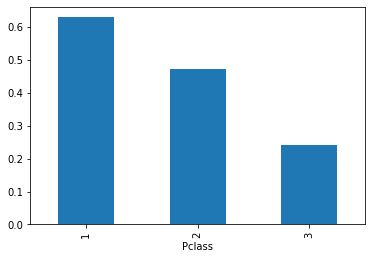

In [231]:
df.groupby(['Pclass'])['Survived'].mean().plot(kind='bar')

<AxesSubplot:xlabel='Sex'>

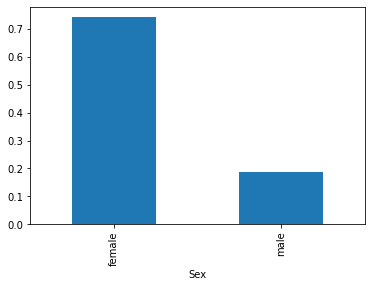

In [232]:
df.groupby(['Sex'])['Survived'].mean().plot(kind='bar')

### Let's come up with new bins 

<AxesSubplot:xlabel='Age_binned_2'>

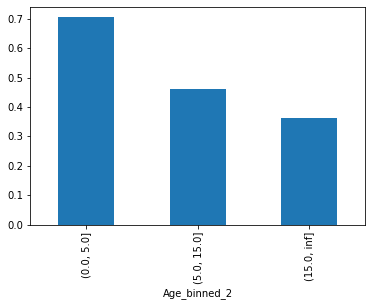

In [233]:
df.groupby(['Age_binned_2'])['Survived'].mean().plot(kind='bar')

In [234]:
age_survived = df.loc[df['Survived'] == 1]['Age']
age_died = df.loc[df['Survived'] == 0]['Age']

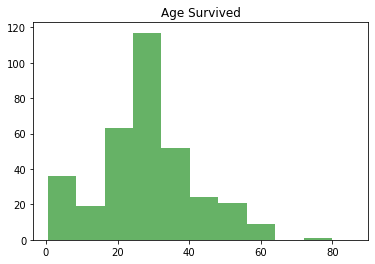

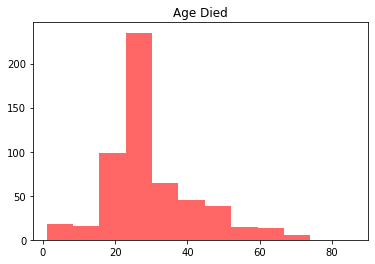

In [235]:
bins=10
plt.hist(age_survived, bins, alpha=0.6, label='survived', color='green')
plt.xlim(right=90)
plt.title("Age Survived")
plt.show()
plt.clf()
plt.hist(age_died, bins, alpha=0.6, label='died', color='red')
plt.xlim(right=90)
plt.title("Age Died")
plt.show()

<AxesSubplot:xlabel='SibSp'>

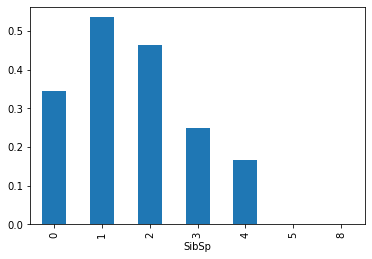

In [236]:
df.groupby(['SibSp'])['Survived'].mean().plot(kind='bar')

In [238]:
df.pivot_table(index='SibSp',
               columns='Survived',
               aggfunc='count',
               values='PassengerId')

Survived,0,1
SibSp,,
0,398.0,210.0
1,97.0,112.0
2,15.0,13.0
3,12.0,4.0
4,15.0,3.0
5,5.0,NaN
8,7.0,NaN


In [239]:
fare_survived = df.loc[df['Survived'] == 1]['Fare']
fare_died = df.loc[df['Survived'] == 0]['Fare']

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

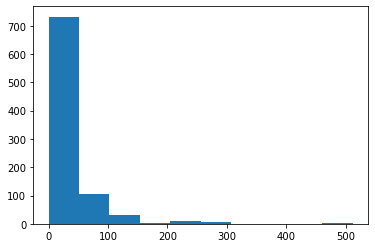

In [241]:
plt.hist(df['Fare'])

In [242]:
df.groupby(['fare_binned'])['Survived'].agg(['mean','count','sum'])

,mean,count,sum
fare_binned,,,
-1,0.066667,15,1
4,0.204698,298,61
9,0.395161,124,49
14,0.371429,70,26
19,0.523810,42,22
24,0.436170,94,41
29,0.441860,43,19
34,0.400000,20,8
39,0.285714,14,4


<AxesSubplot:xlabel='fare_binned'>

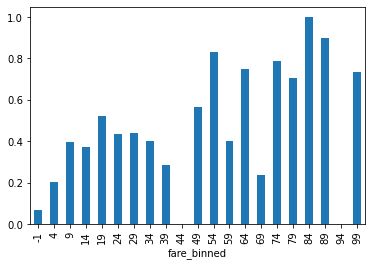

In [243]:
df.groupby(['fare_binned'])['Survived'].mean().plot(kind='bar')

## What if we put the above into a smaller subset of groups?

<AxesSubplot:xlabel='fare_binned_2'>

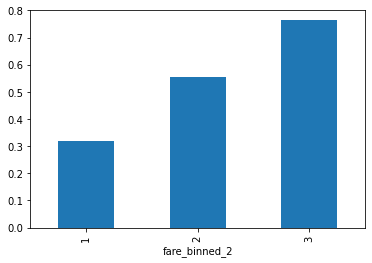

In [244]:
df.groupby(['fare_binned_2'])['Survived'].mean().plot(kind='bar')

## This seems like a good feature to me 

In [245]:
df['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Embarked'>

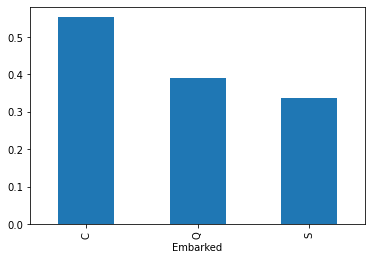

In [246]:
df.groupby(['Embarked'])['Survived'].mean().plot(kind='bar')

## IT ERRORED OUT with a null AGE
- Let's just plug in the default Age for the ones where it's missing for now
- Perhaps there is a better way to infer Age? Maybe based on price of ticket?

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df_features, 
                                                    df_target, 
                                                    test_size=0.20)

# Fit the model to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Score the model on the training data
print(f"CONFUSION:\n{metrics.confusion_matrix(y_test, y_pred)}")

# Score the model on the test data
print(f"MODEL SCORE: {model.score(X_train, y_train)}")
print(f"Model score on test data: {model.score(X_test, y_test)}")

## MODEL COEFFICIENTS 

In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model.coef_.transpose())
coef_table = coef_table.rename(columns={0:'features'})

coef_table['coefs_abs'] = abs(coef_table['Coefs'])

coef_table = coef_table.sort_values('Coefs')
coef_table

## How can we test this model?

## We have no Fare here, so we'll set it to the mean of that Pclass 

In [ ]:
df_test.loc[df_test['Fare'].isnull(),
           'Fare'] = df.groupby(['Pclass'])['Fare'].mean()[3]

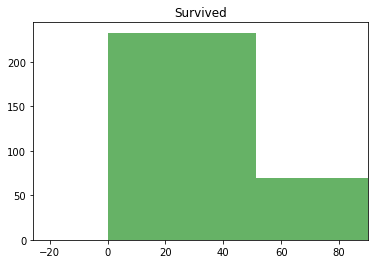

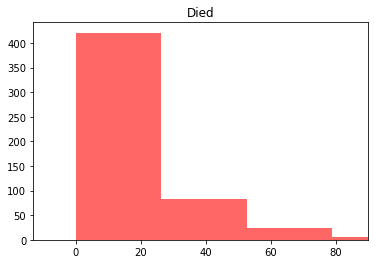

In [247]:
bins=10
plt.hist(fare_survived, bins, alpha=0.6, label='survived', color='green')
plt.xlim(right=90)
plt.title("Survived")
plt.show()
plt.clf()
plt.hist(fare_died, bins, alpha=0.6, label='died', color='red')
plt.xlim(right=90)
plt.title("Died")
plt.show()